Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
import model
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import st_loss

import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import random
import utils
import loop
import pickle
import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
path = "../"
files = glob2.glob(f'{path}real_data/*.h5')
files = [f[len(f"'{path}real_data"):-3] for f in files]
files

['10X_PBMC_select_2100',
 'mouse_ES_cell',
 'worm_neuron_cell_select_2100',
 'worm_neuron_cell',
 'mouse_bladder_cell',
 'mouse_ES_cell_select_2100',
 'mouse_bladder_cell_select_2100',
 '10X_PBMC']

In [3]:
files = [
    '10X_PBMC',
    '10X_PBMC_select_2100',
    'mouse_ES_cell',
    'mouse_ES_cell_select_2100',
    'worm_neuron_cell_select_2100',
    'worm_neuron_cell',
    'mouse_bladder_cell',
    'mouse_bladder_cell_select_2100',

]

In [4]:
df = pd.DataFrame()
for run in range(3):    
    print(df.shape)
    for dataset in files:
        torch.manual_seed(run)
        torch.cuda.manual_seed_all(run)
        np.random.seed(run)
        random.seed(run)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print(f">>>>> Data {dataset}")

        data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])
        print(np.where(X ==0)[0].shape[0]/(X.shape[0]*X.shape[1]))
        cluster_number = np.unique(Y).shape[0]
        nb_genes = 1500
        data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])


        X = train.preprocess(X, nb_genes = nb_genes)

        dresults = train.train(X,
                               cluster_number,
                               dataset,
                               Y,
                               n_ensemble=3,
                               epochs=100,
                               nb_zeros = "random",
                               save_to=f"{path}output/real_data/{run}/")
        
        pxt = PCA(2).fit_transform(X)
        dresults ["original"] = utils.evaluate(X, Y, cluster_number)[1]
        dresults ["pca"] = utils.evaluate(pxt, Y, cluster_number)[1]
        dresults ["run"] = run
        print(dresults)
        df = df.append(dresults, ignore_index=True)
    df.to_pickle(f"{path}output/pickle_results/real_data.pkl")

(0, 0)
>>>>> Data 10X_PBMC
0.9223690984556294
(4271, 16653) (4271, 16653) keeping 1500 genes
..........|..........|..........|{'kmeans_representation_0': 0.47276986960113415, 'leiden_representation_0': 0.41442221416300107, 'kmeans_representation_1': 0.4021831439806861, 'leiden_representation_1': 0.5719399229746117, 'kmeans_representation_2': 0.44491720234874704, 'leiden_representation_2': 0.5207437433532698, 'COMBINED_kmeans': 0.5776214497560284, 'COMBINED_leiden': 0.713075599579578, 'network_0': 0.48652029619206605, 'network_1': 0.43415120352769987, 'network_2': 0.470335396362339, 'dataset': '10X_PBMC', 'cluster_number': 8, 'original': 0.57814, 'pca': 0.22207, 'run': 0}
>>>>> Data 10X_PBMC_select_2100
0.922900120956327
(2100, 16653) (2100, 16653) keeping 1500 genes
..........|..........|..........|{'kmeans_representation_0': 0.3887185700687892, 'leiden_representation_0': 0.4227009536236139, 'kmeans_representation_1': 0.4214590351847921, 'leiden_representation_1': 0.45398566189852135, 

0.9861758600237248
(2100, 13488) (2100, 13488) keeping 1500 genes
..........|..........|..........|{'kmeans_representation_0': 0.22651174921801878, 'leiden_representation_0': 0.22760486368423466, 'kmeans_representation_1': 0.2465317773677702, 'leiden_representation_1': 0.24033818232285348, 'kmeans_representation_2': 0.20859114950170923, 'leiden_representation_2': 0.20640282487090264, 'COMBINED_kmeans': 0.41891523733647634, 'COMBINED_leiden': 0.346380211107125, 'network_0': 0.21433384131550054, 'network_1': 0.2502467236946796, 'network_2': 0.20987104049121208, 'dataset': 'worm_neuron_cell_select_2100', 'cluster_number': 10, 'original': 0.04622, 'pca': 0.18792, 'run': 1}
>>>>> Data worm_neuron_cell
0.9861813427688408
(4186, 13488) (4186, 13488) keeping 1500 genes
..........|..........|..........|{'kmeans_representation_0': 0.3221804010516614, 'leiden_representation_0': 0.31192054466330277, 'kmeans_representation_1': 0.2876068556972322, 'leiden_representation_1': 0.29989904841522186, 'kme

In [8]:
df.groupby("dataset").mean()

,COMBINED_kmeans,COMBINED_leiden,cluster_number,kmeans_representation_0,kmeans_representation_1,kmeans_representation_2,leiden_representation_0,leiden_representation_1,leiden_representation_2,network_0,network_1,network_2,original,pca,run
dataset,,,,,,,,,,,,,,,
10X_PBMC,0.588540,0.627008,8.0,0.466850,0.469963,0.446851,0.499781,0.544616,0.506420,0.491784,0.495597,0.476785,0.57814,0.222070,1.0
10X_PBMC_select_2100,0.585675,0.677475,8.0,0.411139,0.403303,0.395940,0.430690,0.399965,0.444710,0.428437,0.429641,0.424625,0.62993,0.340020,1.0
mouse_ES_cell,0.656451,0.657683,4.0,0.577322,0.535115,0.598454,0.267430,0.336905,0.252951,0.015680,0.014347,0.019242,0.72291,0.753120,1.0
mouse_ES_cell_select_2100,0.740503,0.631700,4.0,0.666233,0.657164,0.617683,0.270213,0.264420,0.241616,0.684403,0.654086,0.641248,0.88681,0.747770,1.0
mouse_bladder_cell,0.383103,0.546637,16.0,0.308297,0.284833,0.300067,0.424292,0.410685,0.441712,0.338912,0.311335,0.334603,0.40146,0.366040,1.0
mouse_bladder_cell_select_2100,0.397222,0.576974,16.0,0.289732,0.297726,0.279070,0.422484,0.412812,0.425227,0.314779,0.323474,0.316475,0.36022,0.394420,1.0
worm_neuron_cell,0.429629,0.352147,10.0,0.302245,0.300068,0.308680,0.305906,0.304478,0.300815,0.301407,0.300815,0.303556,0.08392,0.190820,1.0
worm_neuron_cell_select_2100,0.438779,0.358964,10.0,0.235817,0.202157,0.216726,0.231066,0.220232,0.203572,0.232956,0.210835,0.217244,0.04622,0.185043,1.0


# Importance of input size

In [30]:
df = pd.DataFrame(
    columns=["dataset", "perc0", "nb_genes", "exp", "ari", "run"])
print(df.shape)
for dataset in files:

    print(f">>>>> Data {dataset}")

    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    for run in range(2):
        torch.manual_seed(run)
        torch.cuda.manual_seed_all(run)
        np.random.seed(run)
        random.seed(run)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        for nb_genes in [100, 200, 500, 1000, 1500, 2000, 5000, 8000]:

            X = np.array(data_mat['X'])
            Y = np.array(data_mat['Y'])
            perc_0 = np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1])
            print(f"Perc 0 {perc_0}")
            cluster_number = np.unique(Y).shape[0]

            X = train.preprocess(X, nb_genes=nb_genes)
            nb_zeros = int(0.8 * nb_genes)
            dresults = train.train(
                X,
                cluster_number,
                dataset,
                Y,
                n_ensemble=1,
                epochs=100,
                nb_zeros=nb_zeros,
                save_to=f"{path}output/real_data/inputs/{dataset}_{nb_genes}/")

            #         df.loc[df.shape[0]] = [
            #                 dataset, perc_0, nb_genes, 'kmeans_representation_0',dresults['kmeans_representation_0']
            #             ]
            df.loc[df.shape[0]] = [
                dataset, perc_0, nb_genes, 'leiden_representation_0',
                dresults['leiden_representation_0'], run]

#             pxt = PCA(2).fit_transform(X)
#             dresults["original"] = utils.evaluate(X, Y, cluster_number)[1]
#             dresults["pca"] = utils.evaluate(pxt, Y, cluster_number)[1]
            print(dresults)
    df.to_pickle(f"{path}output/pickle_results/real_data_input_size.pkl")

(0, 6)
>>>>> Data 10X_PBMC
Perc 0 0.9223690984556294
(4271, 16653) (4271, 16653) keeping 100 genes
..........|{'kmeans_representation_0': 0.4772208470801679, 'leiden_representation_0': 0.2318903866382494, 'COMBINED_kmeans': 0.4772208470801679, 'COMBINED_leiden': 0.2318903866382494, 'network_0': 0.42232942709309235, 'dataset': '10X_PBMC', 'cluster_number': 8}
Perc 0 0.9223690984556294
(4271, 16653) (4271, 16653) keeping 200 genes
..........|{'kmeans_representation_0': 0.6475990968225761, 'leiden_representation_0': 0.3924242353704321, 'COMBINED_kmeans': 0.6475990968225761, 'COMBINED_leiden': 0.3924242353704321, 'network_0': 0.6296082566630569, 'dataset': '10X_PBMC', 'cluster_number': 8}
Perc 0 0.9223690984556294
(4271, 16653) (4271, 16653) keeping 500 genes
..........|{'kmeans_representation_0': 0.7159279563123343, 'leiden_representation_0': 0.5187589290081087, 'COMBINED_kmeans': 0.7159279563123343, 'COMBINED_leiden': 0.5187589290081087, 'network_0': 0.7182743427733608, 'dataset': '10X_P

..........|{'kmeans_representation_0': 0.4431014972608026, 'leiden_representation_0': 0.25805332277085785, 'COMBINED_kmeans': 0.4431014972608026, 'COMBINED_leiden': 0.25805332277085785, 'network_0': 0.41050972692257487, 'dataset': '10X_PBMC_select_2100', 'cluster_number': 8}
Perc 0 0.922900120956327
(2100, 16653) (2100, 16653) keeping 200 genes
..........|{'kmeans_representation_0': 0.525380794694869, 'leiden_representation_0': 0.39149604149769596, 'COMBINED_kmeans': 0.525380794694869, 'COMBINED_leiden': 0.39149604149769596, 'network_0': 0.529190842261647, 'dataset': '10X_PBMC_select_2100', 'cluster_number': 8}
Perc 0 0.922900120956327
(2100, 16653) (2100, 16653) keeping 500 genes
..........|{'kmeans_representation_0': 0.574089085252437, 'leiden_representation_0': 0.49608903143800165, 'COMBINED_kmeans': 0.574089085252437, 'COMBINED_leiden': 0.49608903143800165, 'network_0': 0.5545552761450845, 'dataset': '10X_PBMC_select_2100', 'cluster_number': 8}
Perc 0 0.922900120956327
(2100, 16653

Perc 0 0.6597349879351948
(2100, 24175) (2100, 24175) keeping 100 genes
..........|{'kmeans_representation_0': 0.2673189821995251, 'leiden_representation_0': 0.2965412532745913, 'COMBINED_kmeans': 0.2673189821995251, 'COMBINED_leiden': 0.2965412532745913, 'network_0': 0.39757483769928853, 'dataset': 'mouse_ES_cell_select_2100', 'cluster_number': 4}
Perc 0 0.6597349879351948
(2100, 24175) (2100, 24175) keeping 200 genes
..........|{'kmeans_representation_0': 0.32159214775257156, 'leiden_representation_0': 0.451883580853892, 'COMBINED_kmeans': 0.32159214775257156, 'COMBINED_leiden': 0.451883580853892, 'network_0': 0.5172643910553505, 'dataset': 'mouse_ES_cell_select_2100', 'cluster_number': 4}
Perc 0 0.6597349879351948
(2100, 24175) (2100, 24175) keeping 500 genes
..........|{'kmeans_representation_0': 0.32435940827925575, 'leiden_representation_0': 0.4672152133748967, 'COMBINED_kmeans': 0.32435940827925575, 'COMBINED_leiden': 0.4672152133748967, 'network_0': 0.5101158954784546, 'dataset

..........|{'kmeans_representation_0': 0.33758932524893975, 'leiden_representation_0': 0.33636299572865225, 'COMBINED_kmeans': 0.33758932524893975, 'COMBINED_leiden': 0.33636299572865225, 'network_0': 0.3401826145428744, 'dataset': 'worm_neuron_cell_select_2100', 'cluster_number': 10}
Perc 0 0.9861758600237248
(2100, 13488) (2100, 13488) keeping 100 genes
..........|{'kmeans_representation_0': 0.289758286040819, 'leiden_representation_0': 0.20385920027999724, 'COMBINED_kmeans': 0.289758286040819, 'COMBINED_leiden': 0.20385920027999724, 'network_0': 0.2917953453933959, 'dataset': 'worm_neuron_cell_select_2100', 'cluster_number': 10}
Perc 0 0.9861758600237248
(2100, 13488) (2100, 13488) keeping 200 genes
..........|{'kmeans_representation_0': 0.2573075517515131, 'leiden_representation_0': 0.20574650490299376, 'COMBINED_kmeans': 0.2573075517515131, 'COMBINED_leiden': 0.20574650490299376, 'network_0': 0.2728868306766623, 'dataset': 'worm_neuron_cell_select_2100', 'cluster_number': 10}
Perc

Perc 0 0.9861813427688408
(4186, 13488) (4186, 13488) keeping 8000 genes
..........|{'kmeans_representation_0': 0.45389799956498167, 'leiden_representation_0': 0.41078227455357685, 'COMBINED_kmeans': 0.45389799956498167, 'COMBINED_leiden': 0.41078227455357685, 'network_0': 0.45860733572564605, 'dataset': 'worm_neuron_cell', 'cluster_number': 10}
>>>>> Data mouse_bladder_cell
Perc 0 0.9486727054455071
(2746, 20670) (2746, 20670) keeping 100 genes
..........|{'kmeans_representation_0': 0.21669903631183038, 'leiden_representation_0': 0.2433411131886397, 'COMBINED_kmeans': 0.21669903631183038, 'COMBINED_leiden': 0.2433411131886397, 'network_0': 0.2684938137460372, 'dataset': 'mouse_bladder_cell', 'cluster_number': 16}
Perc 0 0.9486727054455071
(2746, 20670) (2746, 20670) keeping 200 genes
..........|{'kmeans_representation_0': 0.31065222767477907, 'leiden_representation_0': 0.3338477652585276, 'COMBINED_kmeans': 0.31065222767477907, 'COMBINED_leiden': 0.3338477652585276, 'network_0': 0.384

Perc 0 0.9489742437855645
(2100, 20670) (2100, 20670) keeping 8000 genes
..........|{'kmeans_representation_0': 0.35625499030435115, 'leiden_representation_0': 0.5059487293463094, 'COMBINED_kmeans': 0.35625499030435115, 'COMBINED_leiden': 0.5059487293463094, 'network_0': 0.3790398851178063, 'dataset': 'mouse_bladder_cell_select_2100', 'cluster_number': 16}
Perc 0 0.9489742437855645
(2100, 20670) (2100, 20670) keeping 100 genes
..........|{'kmeans_representation_0': 0.2962200651382731, 'leiden_representation_0': 0.2823038482286944, 'COMBINED_kmeans': 0.2962200651382731, 'COMBINED_leiden': 0.2823038482286944, 'network_0': 0.4144941738279126, 'dataset': 'mouse_bladder_cell_select_2100', 'cluster_number': 16}
Perc 0 0.9489742437855645
(2100, 20670) (2100, 20670) keeping 200 genes
..........|{'kmeans_representation_0': 0.32165806436219424, 'leiden_representation_0': 0.30284780657460275, 'COMBINED_kmeans': 0.32165806436219424, 'COMBINED_leiden': 0.30284780657460275, 'network_0': 0.3731628872

In [ ]:
df = pd.read_pickle(f"{path}output/pickle_results/real_data_input_size.pkl")

In [31]:
df.groupby(["nb_genes"]).mean()

,perc0,ari
nb_genes,,
100,0.879082,0.246247
200,0.879082,0.342615
500,0.879082,0.445851
1000,0.879082,0.486968
1500,0.879082,0.526701
2000,0.879082,0.533813
5000,0.879082,0.556477
8000,0.879082,0.551937


In [32]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)'
}

df["dataset"] = df["dataset"].apply(lambda x: dataset_names[x])

df = df.rename(columns = {"nb_genes": "Nb input genes"})

In [33]:
df["dataset"].unique()


array(['10X PBMC', '10X PBMC (2100)', 'Mouse ES\nCell',
       'Mouse ES\nCell (2100)', 'Worm Neuron\nCell (2100)',
       'Worm Neuron\nCell', 'Mouse Bladder\nCell',
       'Mouse Bladder\n Cell (2100)'], dtype=object)

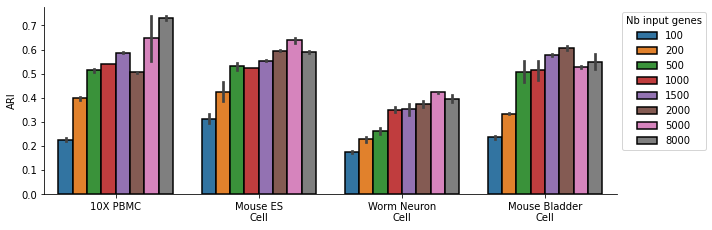

In [34]:
import seaborn as sns
datasets = ['10X PBMC',  'Mouse ES\nCell','Worm Neuron\nCell', 'Mouse Bladder\nCell']
plt.figure(figsize=(10, 3.3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb input genes",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title= "Nb input genes",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_input_size.pdf", bbox_inches='tight')

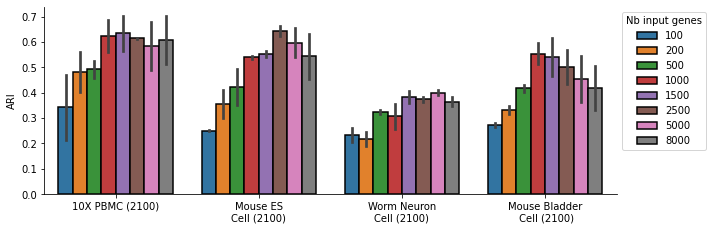

In [25]:
datasets = ['10X PBMC (2100)',
       'Mouse ES\nCell (2100)', 'Worm Neuron\nCell (2100)',
       'Mouse Bladder\n Cell (2100)']
plt.figure(figsize=(10, 3.3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb input genes",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title= "Nb input genes",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_input_size_2100.pdf", bbox_inches='tight')

# Importance of the number of epochs

In [13]:
df = pd.DataFrame(
    columns=["dataset", "perc0", "nb_epochs", "exp", "ari", "run"])
print(df.shape)
for dataset in files:

    print(f">>>>> Data {dataset}")

    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    nb_genes = 1500
    for epochs in [5, 50, 100, 300]:

        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])
        perc_0 = np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1])
        print(f"Perc 0 {perc_0}")
        cluster_number = np.unique(Y).shape[0]

        X = train.preprocess(X, nb_genes=nb_genes)
        nb_zeros = int(0.8 * nb_genes)
        for run in range(2):
            torch.manual_seed(run)
            torch.cuda.manual_seed_all(run)
            np.random.seed(run)
            random.seed(run)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

            dresults = train.train(
                X,
                cluster_number,
                dataset,
                Y,
                n_ensemble=1,
                epochs=epochs,
                nb_zeros=nb_zeros,
                save_to=f"{path}output/real_data/epochs/{dataset}_{epochs}/")

            df.loc[df.shape[0]] = [
                dataset, perc_0, epochs, 'kmeans_representation_0',
                dresults['kmeans_representation_0'], run
            ]
            df.loc[df.shape[0]] = [
                dataset, perc_0, epochs, 'leiden_representation_0',
                dresults['leiden_representation_0'], run
            ]

            print(dresults)
            df.to_pickle(f"{path}output/pickle_results/real_data_epochs.pkl")

(0, 6)
>>>>> Data 10X_PBMC
Perc 0 0.9223690984556294
(4271, 16653) (4271, 16653) keeping 1500 genes
.|{'kmeans_representation_0': 0.6555902098398212, 'leiden_representation_0': 0.5630809820025315, 'COMBINED_kmeans': 0.6555902098398212, 'COMBINED_leiden': 0.5630809820025315, 'network_0': 0.6647515580917316, 'dataset': '10X_PBMC', 'cluster_number': 8}
.|{'kmeans_representation_0': 0.7151842737608171, 'leiden_representation_0': 0.5524413788177304, 'COMBINED_kmeans': 0.7151842737608171, 'COMBINED_leiden': 0.5524413788177304, 'network_0': 0.6942148487202633, 'dataset': '10X_PBMC', 'cluster_number': 8}
Perc 0 0.9223690984556294
(4271, 16653) (4271, 16653) keeping 1500 genes
.....|{'kmeans_representation_0': 0.6113198348564052, 'leiden_representation_0': 0.5595758875205747, 'COMBINED_kmeans': 0.6113198348564052, 'COMBINED_leiden': 0.5595758875205747, 'network_0': 0.5738945440892264, 'dataset': '10X_PBMC', 'cluster_number': 8}
.....|{'kmeans_representation_0': 0.6021534393983584, 'leiden_repre

.....|{'kmeans_representation_0': 0.6603921846021679, 'leiden_representation_0': 0.5887758026151682, 'COMBINED_kmeans': 0.6603921846021679, 'COMBINED_leiden': 0.5887758026151682, 'network_0': 0.7631357079512456, 'dataset': 'mouse_ES_cell_select_2100', 'cluster_number': 4}
Perc 0 0.6597349879351948
(2100, 24175) (2100, 24175) keeping 1500 genes
..........|{'kmeans_representation_0': 0.5516727581559318, 'leiden_representation_0': 0.5569435063970064, 'COMBINED_kmeans': 0.5516727581559318, 'COMBINED_leiden': 0.5569435063970064, 'network_0': 0.34116740297902737, 'dataset': 'mouse_ES_cell_select_2100', 'cluster_number': 4}
..........|{'kmeans_representation_0': 0.591500759117969, 'leiden_representation_0': 0.5462050716522668, 'COMBINED_kmeans': 0.591500759117969, 'COMBINED_leiden': 0.5462050716522668, 'network_0': 0.46237446765402385, 'dataset': 'mouse_ES_cell_select_2100', 'cluster_number': 4}
Perc 0 0.6597349879351948
(2100, 24175) (2100, 24175) keeping 1500 genes
.........................

..........|{'kmeans_representation_0': 0.39498787788444123, 'leiden_representation_0': 0.4694922564115081, 'COMBINED_kmeans': 0.39498787788444123, 'COMBINED_leiden': 0.4694922564115081, 'network_0': 0.4188404123990233, 'dataset': 'mouse_bladder_cell', 'cluster_number': 16}
Perc 0 0.9486727054455071
(2746, 20670) (2746, 20670) keeping 1500 genes
..............................|{'kmeans_representation_0': 0.4363272978847335, 'leiden_representation_0': 0.5325312932411663, 'COMBINED_kmeans': 0.4363272978847335, 'COMBINED_leiden': 0.5325312932411663, 'network_0': 0.46376005152462485, 'dataset': 'mouse_bladder_cell', 'cluster_number': 16}
..............................|{'kmeans_representation_0': 0.39774229215548346, 'leiden_representation_0': 0.5423338150918946, 'COMBINED_kmeans': 0.39774229215548346, 'COMBINED_leiden': 0.5423338150918946, 'network_0': 0.41467245806974967, 'dataset': 'mouse_bladder_cell', 'cluster_number': 16}
>>>>> Data mouse_bladder_cell_select_2100
Perc 0 0.94897424378556

In [11]:
df = pd.read_pickle(f"{path}output/pickle_results/real_data_epochs.pkl")

In [14]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)'
}

df["dataset"] = df["dataset"].apply(lambda x: dataset_names[x])

df = df.rename(columns = {"nb_epochs": "Nb epochs"})

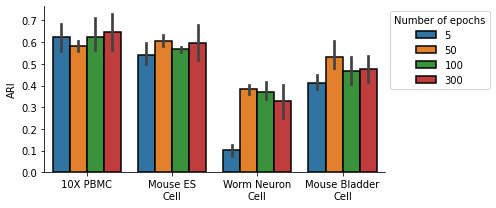

In [20]:
import seaborn as sns
datasets = ['10X PBMC',  'Mouse ES\nCell','Worm Neuron\nCell', 'Mouse Bladder\nCell']
plt.figure(figsize=(7, 3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb epochs",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title ="Number of epochs",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_nb_epochs.pdf", bbox_inches='tight')